<a href="https://colab.research.google.com/github/eviatarbach/variational_filtering/blob/main/Kuramoto_Shivashinksy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
import numpy as np

#adapted from https://github.com/neuraloperator/markov_neural_operator/blob/main/data_generation/KS/ks.m

#Gaussian Random Field
def GRF1(N, m, gamma, tau, sigma, type, L=1):
    if type == "dirichlet":
        m = 0

    if type == "periodic":
        my_const = 2 * np.pi / L
    else:
        my_const = np.pi

    my_eigs = np.sqrt(2) * (abs(sigma) * ((my_const * (np.arange(1, N+1)))**2 + tau**2)**(-gamma/2))

    if type == "dirichlet":
        alpha = np.zeros(N)
    else:
        xi_alpha = np.random.randn(N)
        alpha = my_eigs * xi_alpha

    if type == "neumann":
        beta = np.zeros(N)
    else:
        xi_beta = np.random.randn(N)
        beta = my_eigs * xi_beta

    a = alpha / 2
    b = -beta / 2

    c = np.concatenate([np.flipud(a) - np.flipud(b) * 1j, [m + 0j], a + b * 1j])

    if type == "periodic":
        # For simplicity, directly use numpy's FFT functions for trigonometric interpolation
        return lambda x: np.fft.ifft(np.fft.fftshift(c)).real
    else:
        # Adjust for non-periodic, though this might need further refinement for exact Chebfun behavior
        return lambda x: np.interp(x, np.linspace(-np.pi, np.pi, len(c)), np.fft.ifft(np.fft.fftshift(c)).real)


In [243]:
from scipy.fft import fft, ifft
import numpy as np

def KS_step(u, k, E, E2, Q, f1, f2, f3, g, h):
    v = fft(u)
    Nv = g * fft(np.real(ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * fft(np.real(ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * fft(np.real(ifft(b))**2)
    c = E2 * a + Q * (2*Nb - Nv)
    Nc = g * fft(np.real(ifft(c))**2)
    v_next = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    u_next = np.real(ifft(v_next))

    return u_next

# Precompute constants needed for the time step function
def precompute_constants(s, l, h, M):
    k = (2 * np.pi / l) * np.concatenate([np.arange(0, s//2), [0], np.arange(-s//2+1, 0)])
    L = k**2 - k**4
    E = np.exp(h*L)
    E2 = np.exp(h*L/2)
    r = np.exp(1j * np.pi * (np.arange(1, M+1)-.5) / M)
    LR = h * np.tile(L, (M, 1)).T + np.tile(r, (s, 1))
    Q = h * np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = h * np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = h * np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = h * np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
    g = -0.5j * k

    return k, E, E2, Q, f1, f2, f3, g

# Initial setup
N = 1024  # Spatial discretization
u = np.cos(np.arange(1, N+1) / 16) * (1 + np.sin(np.arange(1, N+1) / 16))  # Initial condition
l = 32 * np.pi  # Domain length
h = 0.25  # Time step
dt = h
M = 64  # Number of points for complex means
s = len(u)  # Length of the state array

# Precompute constants
k, E, E2, Q, f1, f2, f3, g = precompute_constants(s, l, h, M)

# Time-stepping loop
T = 100  # Total time
nmax = round(T/h)
uu = np.empty((nmax, s))  # Array to store state at each time step
uu[0, :] = u  # Set initial condition

for n in range(1, nmax):
    u = KS_step(u, k, E, E2, Q, f1, f2, f3, g, h)
    uu[n, :] = u  # Store the state

# Now, uu contains the state at each time step


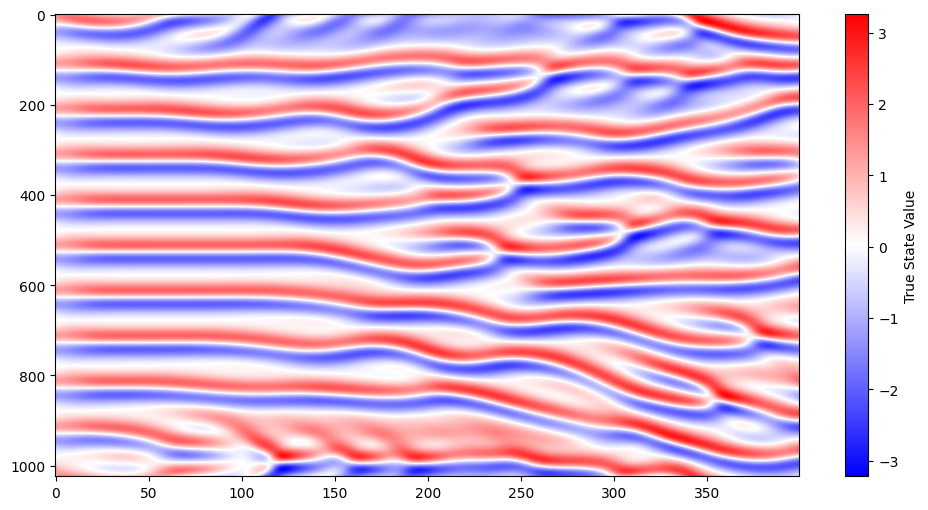

In [244]:
cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])
# Create a separate grid plot for true states
plt.figure(figsize=(12, 6))
plt.imshow(uu.T, cmap=cmap, aspect='auto')
plt.colorbar(label='True State Value')


In [245]:
def generate_observations_from_stored(uu, n_timesteps, observation_interval, R, Q, H):
    observations = {}
    true_states = {}
    for t in range(n_timesteps):
        true_state = uu[t, :]
        true_states[t] = true_state
        if t % observation_interval == 0:
            noisy_state = true_state + np.random.multivariate_normal(np.zeros(true_state.shape[0]), Q)
            observation = H @ noisy_state + np.random.multivariate_normal(np.zeros(H.shape[0]), R)
            observations[t] = observation
    return observations, true_states

H = np.eye(N)  # Assuming full observation for simplicity
Qcov = 0.02 * np.eye(N)  # Model noise covariance
R = 0.2 * np.eye(N) # Observation noise covariance
# Precompute constants for KS_step
k, E, E2, Q_ks, f1, f2, f3, g = precompute_constants(N, l, h, M)

# Define the KS model as a lambda function to match the expected function signature.
KS_model = lambda state, dt: KS_step(state, k, E, E2, Q_ks, f1, f2, f3, g, dt)


time = 100
observation_interval = 10
n_timesteps = int(time/h)
# Set up the initial state
initial_state = np.cos(np.arange(1, N+1) / 16) * (1 + np.sin(np.arange(1, N+1) / 16))

# Assume R, Q, and H are defined as covariance matrices and the observation matrix respectively.
# Now call generate_observations using the KS_model.
observations, true_states = generate_observations_from_stored(uu, n_timesteps, observation_interval, R, Qcov, H)


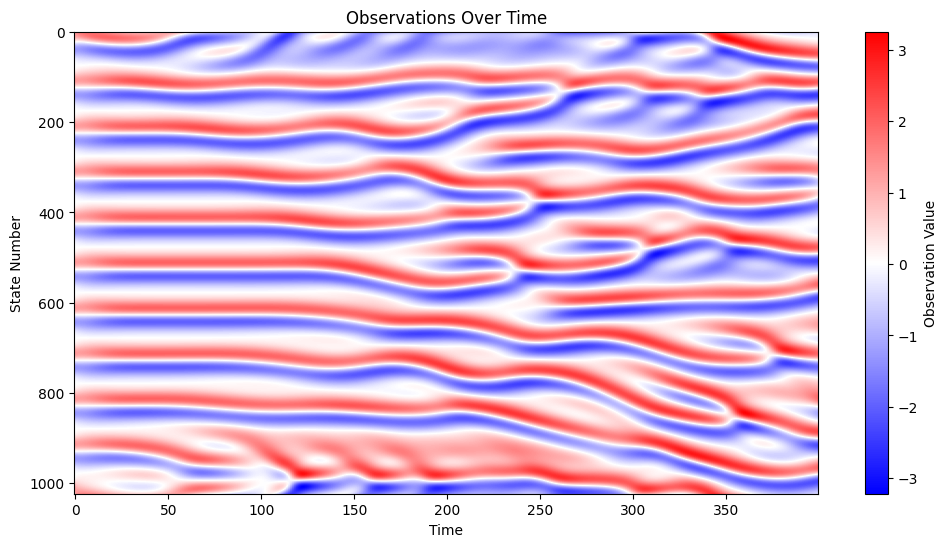

In [246]:
def visualize_observations(observations):
    # Extract timestamps and observation values
    timestamps = list(observations.keys())
    obs = list(observations.values())
    observation_values = np.array(obs).T
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])
    # Create a grid plot
    plt.figure(figsize=(12, 6))
    plt.imshow(observation_values, cmap=cmap, aspect='auto')#, vmin=-6, vmax=6)
    plt.colorbar(label='Observation Value')
    plt.xlabel('Time')
    plt.ylabel('State Number')
    plt.title('Observations Over Time')
    plt.show()
visualize_observations(true_states)

In [247]:
def stochastic_ensemble_kalman_filter(model, state_dim, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, localization_matrix):
    """
    Stochastic Ensemble Kalman Filter generalized for any model.

    :param model: Model function.
    :param state_dim: Dimension of state.
    :param n_ensemble: Number of ensemble members.
    :param n_timesteps: Number of time steps.
    :param dt: Time step size.
    :param H: Observation matrix.
    :param observations: Observations at each time step.
    :param Q: Model noise covariance matrix.
    :return: Dictionary containing states, predictions, and observations over time.
    """
    data_storage = {
        'states': np.zeros((n_timesteps, state_dim, n_ensemble)), # Store the ensemble members' states
        'K_norms': np.zeros((n_timesteps))
    }
    ensemble = ensemble_init

    for t in range(n_timesteps):
        # Forecast step
        data_storage['states'][t] = ensemble

        #forecast = model(ensemble, dt)
        for i in range(n_ensemble):
            ensemble[:, i] = model(ensemble[:, i], dt)


        if t in observations:    # Analysis step if observation is available
            Y_obs = observations[t]
            # Generate and adjust perturbations for each ensemble member's observation
            perturbations = np.array([np.random.multivariate_normal(np.zeros(state_dim), R) for _ in range(n_ensemble)])
            perturbations -= np.mean(perturbations)
            Y_obs_ensemble = np.array([Y_obs + perturbation for perturbation in perturbations])
            R_u = np.cov(perturbations.T)
            # Compute the empirical Kalman gain
            Pf = np.cov(ensemble) + Q
            #print(Pf)
            P = Pf * localization_matrix  # Element-wise multiplication for localization
            K_u = P @ H.T @ np.linalg.pinv(H @ P @ H.T + R_u) #using pinv prevents singularity issues
            data_storage['K_norms'][t] = np.linalg.norm(K_u, 'fro') # K smaller means less trust in observations
            # Update ensemble states
            ensemble = ensemble + K_u @ (Y_obs_ensemble.T - H @ ensemble)
        else:
           pass
    return data_storage

In [248]:
n_ensemble = 10
ensemble_init = np.random.multivariate_normal(initial_state, Qcov, n_ensemble).T
radius = 2
local_mat = np.ones(N)#generate_gc_localization_matrix(N, radius)
# Run the Kalman Filter for Lorenz 96
KS_model = lambda state, dt: KS_step(state, k, E, E2, Q_ks, f1, f2, f3, g, dt)

data_storage = stochastic_ensemble_kalman_filter(KS_model, N, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, local_mat)
average_state = np.mean(data_storage['states'], axis=2)  # Calculate the mean along the ensemble dimension


In [212]:
def plot_ensemble_mean_and_variance(data_storage, true_states, observations, state_index, title_suffix=''):
    """
    Plot the ensemble mean and variance for a specific state index, along with observations.

    :param data_storage: Dictionary containing states, predictions, forecasts, and observations.
    :param state_index: Index of the state to plot (e.g., 0, 1, 2).
    :param title_suffix: Suffix for the plot title.
    """
    time_steps = np.arange(len(data_storage['states']))

    # Calculate the mean and standard deviation of the forecasts
    forecast_mean = np.mean(data_storage['states'][:, state_index, :], axis=1)
    forecast_std = np.std(data_storage['states'][:, state_index, :], axis=1)

    plt.figure(figsize=(12, 8))

    # Plot the mean of the forecasts
    plt.plot(time_steps, forecast_mean, label='Forecast Mean', color='orange')
    states = [arr[1][state_index] for arr in true_states.items()]

    plt.plot(time_steps, states, label='True States')

    # Plot a 95% confidence interval for the forecasts
    plt.fill_between(time_steps,
                     forecast_mean - 1.96 * forecast_std,
                     forecast_mean + 1.96 * forecast_std,
                     color='orange', alpha=0.3, label='95% Confidence Interval')

    # Plot the observations
    observed_time_steps = observations.keys()
    observed_values = [observations[t][state_index] for t in observed_time_steps]
    plt.scatter(observed_time_steps, observed_values, label='Observation', color='red')

    plt.title(f'State {state_index+1} Ensemble Mean and Variance {title_suffix}')
    plt.xlabel('Time Step')
    plt.ylabel(f'State {state_index+1} Value')
    plt.legend()
    plt.show()


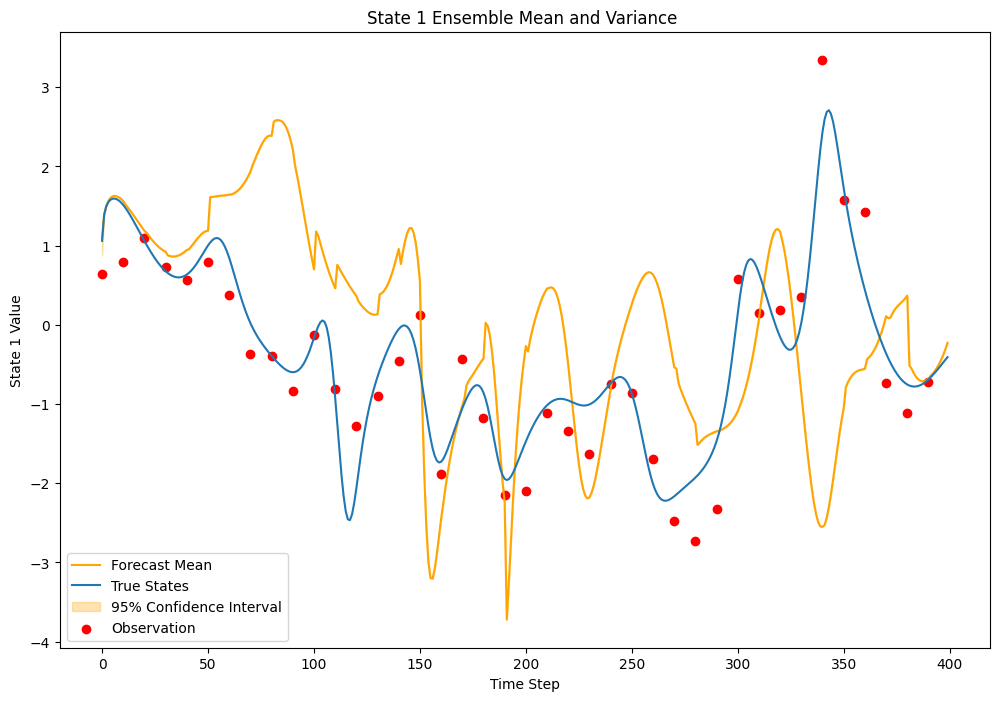

In [249]:
plot_ensemble_mean_and_variance(data_storage, true_states, observations, 0, title_suffix='')